# Decaying network (parrot neurons)


- a network of 100 excitatory cells without any recurrent connections and inhibitions

## define fileName, saving path and libraries

In [1]:
# fileName

fileName = 'eg_decaying-network' 

In [2]:
# spinnaker and brian

In [3]:
try:
    import pyNN.spiNNaker as sim
except ModuleNotFoundError:
    import pyNN.brian2 as sim
    
from pyNN import space 
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time
import datetime
import json
import warnings
warnings.filterwarnings('ignore')
import python_utils as pu
%matplotlib inline

savePath = f'../outputs/' # remember to create the folder if not already present (mkdir ./notebooks/outputs)
dt_string = datetime.datetime.today().isoformat() # ISO8601 ! :-)
tag = dt_string 
saveName = f'{savePath}{fileName}-{tag}'
print(saveName)
PARS={}


WARNING    /home/jovyan/CNT-2025/notebooks/intro/python_utils.py:25: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF
 [py.warnings]


../outputs/eg_decaying-network-2025-12-01T11:03:36.763835


## simulations settings

In [4]:
sim.setup(
        timestep=1, # [ms]
        min_delay=1, # [ms]
        max_delay=100) # [ms]

simtime = 250 #ms

## network design

In [5]:
pops = {}
n_cells = {}
neuron_Model = {}
neuron_ModelPars = {}
initial_Values = {}

for popName in ['network']:
    n_cells[popName] = 100
    neuron_Model[popName] = sim.IF_cond_exp
    neuron_ModelPars[popName] = sim.IF_cond_exp.default_parameters # or standard_pars or testing_pars
    initial_Values[popName] = sim.IF_cond_exp.default_initial_values
    pops[popName] = sim.Population(n_cells[popName], 
                                   neuron_Model[popName],
                                   neuron_ModelPars[popName],
                                   structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0),
                                   label = popName)

    pops[popName].record(['spikes','v','gsyn_exc','gsyn_inh'])   
 


WARNING    /opt/conda/lib/python3.13/site-packages/pyNN/common/populations.py:680: DeprecationWarning: Passing celltype class and parameters separately is deprecated. Please instantiate the celltype with the parameters before passing to the Population
  warnings.warn(
 [py.warnings]


## input design

WARNING    Removing unsupported flag '-w' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Removing unsupported flag '-O3' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Removing unsupported flag '-ffast-math' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Removing unsupported flag '-fno-finite-math-only' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Removing unsupported flag '-std=c++11' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Cannot use Cython, a test compilation failed: command 'g++' failed: Permission denied (CompileError)
Certain compiler configurations (e.g. clang in a conda environment on OS X) are known to be problematic. Note that you can switch the compiler by setting the 'CC' and 'CXX' environment variables. For example, you may want to try 'CC=gcc' and 'CXX=g++'. [brian2.codegen.runtime.cython_rt.cython_rt.fai

array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59])

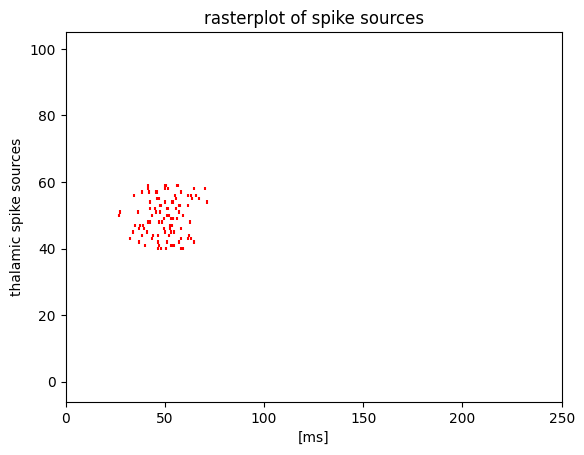

In [6]:
# make the thalamic input sources

popName = 'Thalamus'  

n_cells[popName] = n_cells['network']
spike_times = [[]]*n_cells[popName] #list of spike lists, where one spike list is related to one spike source
#random_sources_idx = [np.random.randint(n_cells[popName]*0.40, n_cells[popName]*0.60) for i in range(n_cells[popName])]
random_sources_idx = np.arange(int(n_cells[popName]*0.40), int(n_cells[popName]*0.60))

for idx, sources in enumerate(random_sources_idx):
    spike_times[sources] = np.sort([abs(np.random.normal(loc=50, scale=10)) for n in range(5)])

neuron_Model[popName] = sim.SpikeSourceArray(spike_times=spike_times)


pops[popName] = sim.Population(n_cells[popName], 
                               neuron_Model[popName],
                               structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0),
                               label = popName)

proj = {}
proj['Thalamus', 'network'] = sim.Projection(pops['Thalamus'], 
                                         pops['network'],
                                         connector = sim.OneToOneConnector(),
                                         synapse_type = sim.StaticSynapse(weight=0.08, delay=1),
                                         space = space.Space(axes = 'x'),
                                         receptor_type = 'excitatory',
                                         label = 'thalamus-network connections')

fig, axes = plt.subplots(1,1)
axes_list = fig.axes
axes_list[0].eventplot(spike_times, color='r')
axes_list[0].set_xlabel('[ms]')
axes_list[0].set_ylabel('thalamic spike sources')
axes_list[0].set_title('rasterplot of spike sources')
axes_list[0].set_xlim(0, simtime)

random_sources_idx

## run the simulations

In [7]:
tic = time.time()
sim.run(simtime)
toc = time.time() - tic

INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.04s). [brian2.stateupdaters.base.method_choice]
WARNING    Note that the synaptic pathway 'synapses_pre' will run on the clock of the group 'spikegeneratorgroup' using a dt of 100. us. Either the Synapses object 'synapses' or the target 'neurongroup' (or both) are using a different dt. This might lead to unexpected results. In particular, all delays will be rounded to multiples of 100. us. If in doubt, try to ensure that 'spikegeneratorgroup', 'synapses', and 'neurongroup' use the same dt. [brian2.synapses.synapses.synapses_dt_mismatch]


## save and recover stateVars

In [8]:
stateVars = {}
for pop in pops.keys():
    for recording in ['v', 'gsyn_inh', 'gsyn_exc', 'spikes']:
        pops[pop].write_data(f'{saveName}-{recording}.pkl')
        stateVars[pop]=pops[pop].get_data()

stateVars.keys()
results = pu.recover_results(stateVars)
results.keys()

WARNING    /opt/conda/lib/python3.13/site-packages/pyNN/brian2/recording.py:77: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  mask = np.in1d(id_array, requested_ids)
 [py.warnings]
WARNING    /opt/conda/lib/python3.13/site-packages/pyNN/brian2/recording.py:77: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  mask = np.in1d(id_array, requested_ids)
 [py.warnings]
WARNING    /opt/conda/lib/python3.13/site-packages/pyNN/brian2/recording.py:77: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  mask = np.in1d(id_array, requested_ids)
 [py.warnings]
WARNING    /opt/conda/lib/python3.13/site-packages/pyNN/brian2/recording.py:77: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  mask = np.in1d(id_array, requested_ids)
 [py.warnings]
WARNING    /opt/conda/lib/python3.13/site-packages/pyNN/brian2/recording.py:77: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  mask = np.in1d(id_array, requested_ids)
 [py.

network
v
gsyn_exc
gsyn_inh
Thalamus


dict_keys([('network', 'v'), ('network', 'gsyn_exc'), ('network', 'gsyn_inh'), ('network', 'spikes'), ('Thalamus', 'spikes')])

## postprocessing

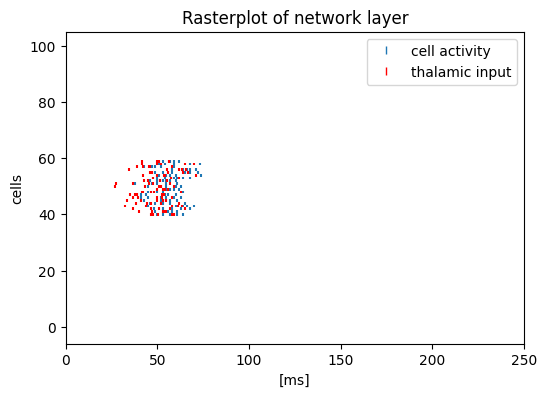

In [9]:
import matplotlib.lines as mlines
fig, axes = plt.subplots(1, 1)
fig.tight_layout(pad=5)
axes_list = fig.axes

for idx, value in enumerate(['network']):
    ax = axes_list[idx]

    cell_handle = mlines.Line2D([], [], color='C0', linestyle='None', marker='|', label='cell activity')
    thal_handle = mlines.Line2D([], [], color='r', linestyle='None', marker='|', label='thalamic input')

    ax.eventplot(results[value, 'spikes'], colors='C0')
    ax.eventplot(spike_times, colors='r')

    ax.set_title('Rasterplot of ' + str(value) + ' layer')
    ax.set_xlabel('[ms]')
    ax.set_ylabel('cells')
    ax.set_xlim(0, simtime)

    ax.legend(handles=[cell_handle, thal_handle])


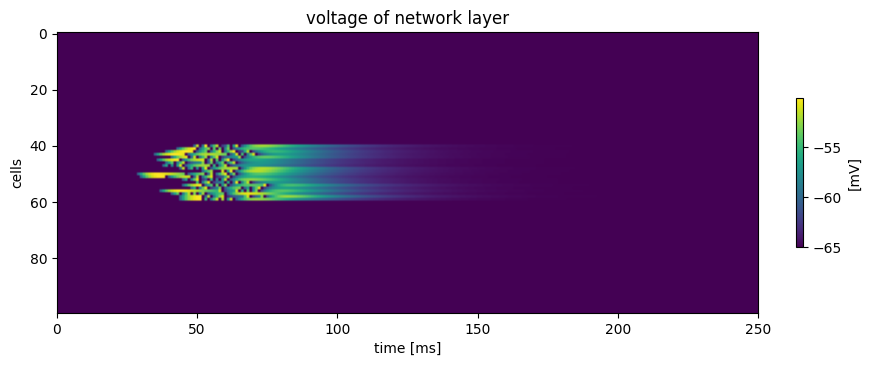

In [10]:
# check the voltage

fig, axes = plt.subplots(1, 1, figsize=(9,9))
fig.tight_layout(pad=4)

axes_list = fig.axes

for idx, value in enumerate(['network']):
    im = axes_list[idx].imshow(results[value, 'v'].T)
    axes_list[idx].set_title('voltage of ' + str(value) + ' layer')
    axes_list[idx].set_xlabel('time [ms]')
    axes_list[idx].set_ylabel('cells')
    axes_list[idx].set_xlim(0, simtime)
    fig.colorbar(im, ax=axes_list[idx], fraction=0.010, label='[mV]')

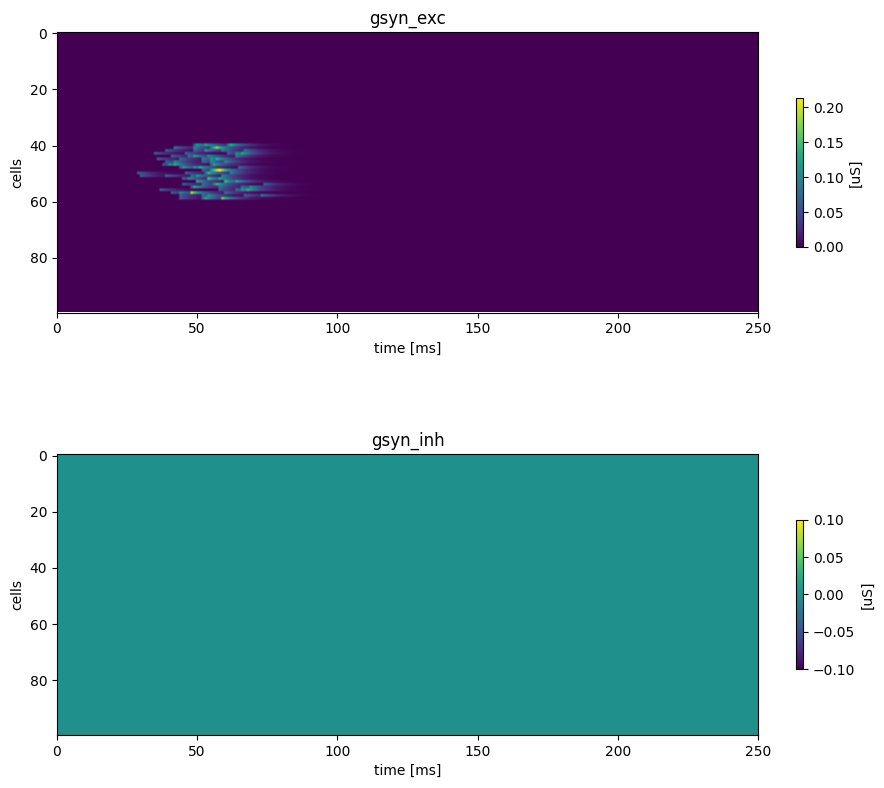

In [11]:
# check the conductances

# check the voltage

fig, axes = plt.subplots(2, 1, figsize=(9,9))
fig.tight_layout(pad=4)

axes_list = fig.axes

for idx, value in enumerate(['network']):
    for idx, gsyn in enumerate(['gsyn_exc', 'gsyn_inh']):
        im = axes_list[idx].imshow(results['network', gsyn].T)
        axes_list[idx].set_title(str(gsyn))
        axes_list[idx].set_xlabel('time [ms]')
        axes_list[idx].set_ylabel('cells')
        axes_list[idx].set_xlim(0, simtime)
        fig.colorbar(im, ax=axes_list[idx], fraction=0.010, label='[uS]')

## end simulation

In [12]:
sim.end()

# remember that if you end the simulation, 
# than some PyNN routines are not working anymore, 
# so close only at the very end of your analysis